In [1]:
# !pip install peft

In [2]:
# !pip install matplotlib

In [3]:
# https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms
# https://anirbansen2709.medium.com/finetuning-llms-using-lora-77fb02cbbc48
# https://github.com/microsoft/LoRA/tree/main/examples/NLG
# https://github.com/huggingface/peft


In [1]:
import sys
import gc
import torch
# sys.path.append('/home/blatova/lca-solvers/')
# sys.path.append('/home/glu/lca-solvers/')

from torch.utils.data import DataLoader
from torch.optim import AdamW
import math
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import re
import string

punctuation = string.punctuation
punctuation += "–—‘’“”…"
pattern = re.compile(r'^[a-zA-Z0-9\s' + re.escape(punctuation) + r']*$')

In [2]:
from tqdm.auto import tqdm

In [3]:
import os

proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(proj_dir)

In [4]:
import random

from transformers import AutoTokenizer, AutoModelForCausalLM

from data_filters.repo_snapshot_filter_stack import SnapshotFilterStack
from data_classes.datapoint_composed import DatapointComposed
from data_loading.raw_train_dataset_loading import DataLoaderTrainRaw
from data_loading.composer_train_dataset_loading import DataLoaderTrainComposed
from context_composers.context_composer_path_distance import ContextComposerPathDistance
from data_classes.datapoint_composed import DatapointComposed
from datasets import load_dataset
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from torch.utils.data import Dataset, DataLoader

# NUM_FILES=250

# class ContextComposerTestLength(ContextComposerBase):
#     def __init__(self):
#         super().__init__()
#         pass

#     def compose_context(self, datapoint: DatapointBase, num_files=2) -> str:
#         relevant_context = datapoint.get_relevant_context()
#         non_relevant_context = datapoint.get_non_relevant_context()
#         context =""
#         for i in range(num_files):
#             filename = random.choice(list(relevant_context))
#             content= relevant_context[filename]
#             context=context+f"# {filename}\n\n{content}\n\n"
#         return context

In [5]:
!nvidia-smi

Wed May 15 22:12:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   29C    P8              12W / 450W |  21974MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# !kill -9 1694536

In [7]:
# loader = DataLoader(cache_dir="/home/blatova/cache_dir")
# loader = DataLoaderTrainComposed(
#         hf_path='JetBrains-Research/context-py-train',
#         hf_config=None,
#         cache_dir='/mnt/data2/shared-data/lca/hf_cache2/',
#     )
composer = ContextComposerPathDistance()
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True, torch_dtype=torch.bfloat16).to("cuda:3")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Lora parameters

https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db

https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms

https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-2-d8e23877ac6f

AdaMix Lora: https://arxiv.org/pdf/2210.17451v1

Lora-based mixture of experts: https://arxiv.org/pdf/2404.15159

I believe the modules you've mentioned: gate_proj, down_proj, up_proj, q_proj, v_proj, k_proj, and o_proj, are all linear layers. So, they should be included in the list for LoRA finetuning to get the best results, that compare to full finetuning.

This is based on the QLoRA paper: "We find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers is required to match full finetuning performance."

To check which layers are linear, you can load the model with the transformers library in Python and then just print(model). The layers to look for will be labeled Linear or Linear4bit if you load the model in 4-bit. While I can't say this is the only way, it's how I've always done it.

For QLoRA finetuning, I've used my own custom script, so I wrote a function that returns a list to simplify the "finding layers to finetune" process. However, keep in mind, this function will work properly only if the model is loaded in 4-bit using the transformers library:

```def find_target_modules(model):
    # Initialize a Set to Store Unique Layers
    unique_layers = set()
    
    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear4bit'
        if "Linear4bit" in str(type(module)):
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]
            
            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)```
From: https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/

```import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))```


Better result about layers and parameters fine-tuning:

https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms : All linear layers

***Other parameters:***

***Optimizer: Commonly used AdamW***

r=16 => alpha = 16 (That’s why the authors set α to the first r and do not tune it. The default of α is 8.)

***r=32 => alpha = 32***

Dropout rate: 

https://ar5iv.labs.arxiv.org/html/2403.00812

https://arxiv.org/pdf/2403.00812

https://arxiv.org/pdf/2404.09610

Hence, we only introduce the dropping in the latter half of layers in decoder-only models and the apparent performance improvement emerges again.

***Dropout rate: Start without dropout? Usually used 0.1 ***

bias: ???




In [8]:
# ds = load_dataset('JetBrains-Research/context-py-train', 'path_distance_relevant', cache_dir = '/mnt/data2/shared-data/lca/hf_cache2/')
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=32, lora_dropout=0.1, 
    target_modules='all-linear'
)

model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()


trainable params: 29,982,720 || all params: 1,376,454,656 || trainable%: 2.178257007545042


In [9]:
for n, p in model_lora.named_parameters():
    if '.embed_tokens.' in n or '.norm' in n or 'lm_head' in n: # or 'layernorm' in n or 'layers.22' in n:
        print(n, p.requires_grad, end='--->')
        p.requires_grad_(requires_grad=True)
        print(p.requires_grad)

base_model.model.model.embed_tokens.weight False--->True
base_model.model.model.norm.weight False--->True
base_model.model.lm_head.weight False--->True


In [10]:
model_lora.print_trainable_parameters()

AttributeError: 'LlamaForCausalLM' object has no attribute 'print_trainable_parameters'

In [8]:
#6000 tokens => OOM
ACCUM_STEPS_NUM = 64
CONTEXT_MAX_LEN_CHARS = 32000
CONTEXT_MAX_LEN_TOKENS = 12000

In [9]:
criterion = CrossEntropyLoss()
optimizer = AdamW(model_lora.parameters(), lr=5e-5)

In [13]:
def forget_lines(text, prob=0.5, seed=27):
    rand = random.Random()
    rand.seed(seed)
    first_line = text.split('\n')[0]
    last_line = text.split('\n')[-1]
    text_after_forget = '\n'.join([line for line in text.split('\n')[1:-1] if rand.random()>prob])
    return first_line + text_after_forget + last_line

In [14]:
text = '''
yrte
oirt 
iuyter

12
3
4

'''

print(forget_lines(text, seed=-2))
# print(text.split(''))

yrte
oirt 
12
3
4


In [11]:
def compose_input_sequence(dp: DatapointComposed, max_len_tokens: int, tokenizer, context_ratio: float = 0.75, 
                           cut_context=True, ctxt_forg_prob=-1.) -> str:
    #here we will probably get a little bit less than a real number of tokens
    approx_max_len_chars = max_len_tokens * 3
    
    if not -1e8 < context_ratio < 1. + 1e8:
        raise ValueError('context_ratio must be between 0 and 1')

    context = dp.context[0]
    completion = dp.completion[0]
    context = '\n'.join([line for line in context.split('\n') if re.match(pattern, line)])
    completion = '\n'.join([line for line in completion.split('\n') if re.match(pattern, line)])

    context = forget_lines(context, prob=ctxt_forg_prob, seed=len(context))

    length_context = int(approx_max_len_chars * context_ratio) + 1
    length_completion = int(approx_max_len_chars * (1 - context_ratio)) + 1

    compl_trim_idx = completion.rfind('\n', 0, length_completion)
    context_trim_idx = context.find('\n', len(context)-length_context, len(context))

    if compl_trim_idx > 0:
        # print("First cut of completion")
        completion_trimmed = completion[:compl_trim_idx]
    else:
        # print("Second cut of completion")
        completion_trimmed = completion[:length_completion]
    if context_trim_idx > 0:
        # print("First cut of context")
        context_trimmed = context[1+context_trim_idx:]
    else:
        # print("Second cut of context")
        context_trimmed = context[-length_context:]
    
    context_len = tokenizer(context_trimmed, return_tensors="pt")['input_ids'].shape[1]
    completion_len = tokenizer(completion_trimmed, return_tensors="pt")['input_ids'].shape[1]
    res_input = tokenizer(context_trimmed + completion_trimmed, return_tensors="pt")
    
    if completion_len>=length_completion:
        # print(f"Very strange output: completion_len>=length_completion: {completion_len}>={length_completion}. Skipping")
        # print(completion_trimmed)
        return None, None, None
    if context_len>=length_context:
        # print(f"Very strange output: context_len>=length_context: {context_len}>={length_context}. Skipping")
        # print(completion_trimmed)
        return None, None, None
    if 2*completion_len>=length_completion:
        pass
        # print(f"Look here: 2*completion_len>=length_completion: 2*{completion_len}>={length_completion}. Not skipping")
        # print(completion_trimmed)
    if 2*context_len>=length_context:
        pass
        # print(f"Look here: 2*context_len>=length_context: 2*{context_len}>={length_context}. Not skipping")
        # print(completion_trimmed)
    
        
    # print(f"context_len: {context_len}, completion_len: {completion_len}")
    # # if completion_len>1000:
    #     # print(completion_trimmed)
    # print(f"length_context:{length_context}, length_completion:{length_completion}, len(context_trimmed): {len(context_trimmed)}, len(completion_trimmed): {len(completion_trimmed)}")
    # print(f"context_trim_idx:{context_trim_idx}, len(context): {len(context)}, compl_trim_idx:{compl_trim_idx}, len(completion): {len(completion)}")
    if len(completion_trimmed)<completion_len:
        print(completion_trimmed)
    diff_tokens = 0
   
    if (context_len+completion_len > max_len_tokens):
        diff_tokens = context_len+completion_len - max_len_tokens
        if cut_context:
            res_input['input_ids'] =res_input['input_ids'][:, diff_tokens:]
            res_input['attention_mask'] =res_input['attention_mask'][:,diff_tokens:]
            context_len = context_len - diff_tokens
        else:
            res_input['input_ids'] =res_input['input_ids'][:, :-diff_tokens]
            res_input['attention_mask'] =res_input['attention_mask'][:,:-diff_tokens]
            completion_len = completion_len - diff_tokens
            
    
    return res_input, context_len, completion_len



First cut of completion
First cut of context
context_len: 1222, completion_len: 
length_context:4501, length_completion:1501, len(context_trimmed): 4474, len(completion_trimmed): 1469
context_trim_idx:995525, len(context): 1000000, compl_trim_idx:1469, len(completion): 20843

In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def live_plot(data1, data2, valdata1, valdata2, figsize=(10, 10), title1='Loss on whole sequence', title2='Loss on completion'):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)  # Creates 2 subplots vertically aligned
    
    # Plotting data1 on the first subplot
    ax1.plot(data1, marker='o')
    ax1.plot(valdata1, marker='_')
    ax1.set_title(title1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plotting data2 on the second subplot
    ax2.plot(data2, marker='o')
    ax2.plot(valdata2, marker='_')
    ax2.set_title(title2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
 # hf_path='JetBrains-Research/context-py-train',
#         hf_config=None,
#         cache_dir='/mnt/data2/shared-data/lca/hf_cache2/'

In [14]:
dataset = load_dataset("JetBrains-Research/context-py-train", "path_distance_relevant", cache_dir='/mnt/data2/shared-data/lca/hf_cache/')

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [15]:
rng = random.Random()
rng.seed(111)

val_repos = rng.sample(list(set(dataset['train']['repo'])), 48)

In [16]:
class HFDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset['train']
    
    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        return self.hf_dataset[idx]

class HFDatasetVal(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset['test']
    
    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        return self.hf_dataset[idx]



train_dataset = dataset.filter(lambda ex: not any([ex['repo']==vp for vp in val_repos]))
val_dataset = dataset.filter(lambda ex: any([ex['repo']==vp for vp in val_repos]))['train'].train_test_split(test_size=128, seed=111)
# dataset = load_dataset('JetBrains-Research/context-py-train', cache_dir='/mnt/data2/shared-data/lca/hf_cache2/')
torch_dataset = HFDataset(train_dataset)
val_torch_dataset = HFDatasetVal(val_dataset)
loader = DataLoader(torch_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_torch_dataset, batch_size=1,)

print(len(loader), len(val_loader))

Filter:   0%|          | 0/13799 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13799 [00:00<?, ? examples/s]

12882 128


In [17]:
dataset, train_dataset, val_dataset

(DatasetDict({
     train: Dataset({
         features: ['repo', 'commit_hash', 'context', 'completion_file', 'context_strategy'],
         num_rows: 13799
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['repo', 'commit_hash', 'context', 'completion_file', 'context_strategy'],
         num_rows: 12882
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['repo', 'commit_hash', 'context', 'completion_file', 'context_strategy'],
         num_rows: 789
     })
     test: Dataset({
         features: ['repo', 'commit_hash', 'context', 'completion_file', 'context_strategy'],
         num_rows: 128
     })
 }))

In [18]:
def ema_smoothing(values, alpha=0.05):
    """
    Calculate the exponential moving average of a list of values using a specified alpha.

    :param values: List of float, the data points to smooth.
    :param alpha: Float, the smoothing factor, often calculated as 2 / (period + 1).
    :return: List of float, the smoothed data points.
    """
    ema = [values[0]]  # Start the EMA with the first value in the list
    for value in values[1:]:
        ema.append(ema[-1] * (1 - alpha) + value * alpha)
    return ema

In [17]:
model.device

NameError: name 'model' is not defined

In [19]:
def get_outputs(input_ids, context_len, completion_len, model, val=False, token_factor=2):
    # ctxt_input_ids = input_ids[..., :completion_len]
    try:
        embeds = model.model.embed_tokens(input_ids.to(model.device))
    except AttributeError:
        embeds = model.base_model.model.model.embed_tokens(input_ids.to(model.device))
    context_embeds = embeds[..., :context_len, :]
    completion_embeds = embeds[..., context_len:, :]
    if context_embeds.shape[-2] % token_factor != 0:
        
        extra_tokens = token_factor - context_embeds.shape[-2] % token_factor
        # print(context_embeds.shape[-2], extra_tokens, end=' | ')
        padding_tensor = torch.zeros_like(context_embeds[..., :extra_tokens, :]).detach()
        context_embeds = torch.cat((padding_tensor, context_embeds), dim=-2)
    new_shape = (context_embeds.shape[0], context_embeds.shape[1] // token_factor, token_factor, context_embeds.shape[2])
    # print(context_embeds.shape[1] // token_factor, context_embeds.shape[1] % token_factor)
    paired_context_embeds = context_embeds.view(new_shape).sum(dim=-2) / token_factor

    new_embeds = torch.cat((paired_context_embeds, completion_embeds), dim=-2)
    # print(embeds.shape, '---->', new_embeds.shape)
    outputs = model(inputs_embeds=new_embeds)
    if val:
        return outputs, model(input_ids[:, -((token_factor-1) * context_len + 1):])
    return outputs
    

In [25]:
seq_len = 2048
context_ratio = 0.75
true_completion_lens = list()
for idx, hf_dp in enumerate(tqdm(val_loader)):
    dp = DatapointComposed.from_hf_datapoint(hf_dp)
    true_completion_lens.append(compose_input_sequence(dp, seq_len, tokenizer, context_ratio)[-1])

  0%|          | 0/128 [00:00<?, ?it/s]

In [26]:
true_completion_lens[-1]

431

In [29]:
def get_val_loss(model, val_loader=val_loader, token_factor=1, true_completion_lens=None):
    count = 0
    curr_val_loss_whole_input = list()
    curr_val_loss_completion = list()
    with torch.no_grad():
        for idx, hf_dp in enumerate(tqdm(val_loader)):
            # if idx>20:
            #     break
            dp = DatapointComposed.from_hf_datapoint(hf_dp)
            seq_len = 2048
            context_ratio = 0.75
            # true_completion_len = int(seq_len*(1-context_ratio))
            inputs, context_len, completion_len = compose_input_sequence(dp, int(seq_len * (1 + (token_factor-1)*context_ratio)), tokenizer, context_ratio)
            if inputs is None:
                continue
            input_ids = inputs['input_ids'].clone()
            # if true_completion_lens is not None:
            #     completion_len = true_completion_lens[idx]
            
            # inputs['input_ids'] = inputs['input_ids'][:, :(context_len + true_completion_len)] 
                # input_ids = input_ids[:, :(context_len + completion_len)]
            count += 1
            inputs = inputs.to(model_lora.device)
            # outputs, t_outputs = get_outputs(inputs['input_ids'], context_len, completion_len, model, val=True)
            # outputs = model.forward(**inputs)
            outputs = get_outputs(input_ids, context_len, completion_len, model, token_factor=token_factor)
        
            logits_size = outputs['logits'].size(-1)
            loss_completion = criterion(
                outputs['logits'].view(-1, outputs['logits'].size(-1))[-completion_len:-1, :], 
                inputs['input_ids'].view(-1)[-completion_len+1:])
            # t_logits_size = t_outputs['logits'].size(-1)
            # t_loss_completion = criterion(t_outputs['logits'].view(-1, t_outputs['logits'].size(-1))[-completion_len:-1, :], inputs['input_ids'].view(-1)[-completion_len+1:])

            
            detached_logits = outputs['logits'].detach()
            # if idx < 20:
                # print(f'With pairing: {loss_completion.item():.4f}, Standard: {t_loss_completion.item():.4f}')
            # for 0 output logit we have corresponding 1st input
            loss_whole_input = loss_completion #criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:])
            curr_val_loss_whole_input.append(loss_whole_input.item())
            curr_val_loss_completion.append(loss_completion.item())
    print(f'Token Factor: {token_factor}, Loss: {sum(curr_val_loss_completion) / len(curr_val_loss_completion) :.4f}, ',
            f'input shape: {inputs["input_ids"].shape}, output shape: {outputs.logits.shape}')

    return sum(curr_val_loss_whole_input) / len(curr_val_loss_whole_input), sum(curr_val_loss_completion) / len(curr_val_loss_completion), count

In [30]:
for tf in range(4, 16):
    get_val_loss(model_lora, token_factor=tf, true_completion_lens=true_completion_lens)
    # print(f'Token Factor: {tf}, val_loss: {get_val_loss(model_lora, token_factor=tf)[0]:.4f}')

  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 4, Loss: 0.7351,  input shape: torch.Size([1, 5647]), output shape: torch.Size([1, 2472, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
get_val_loss(model_lora)

  0%|          | 0/128 [00:00<?, ?it/s]

(0.8074252358055674, 0.8074252358055674, 128)

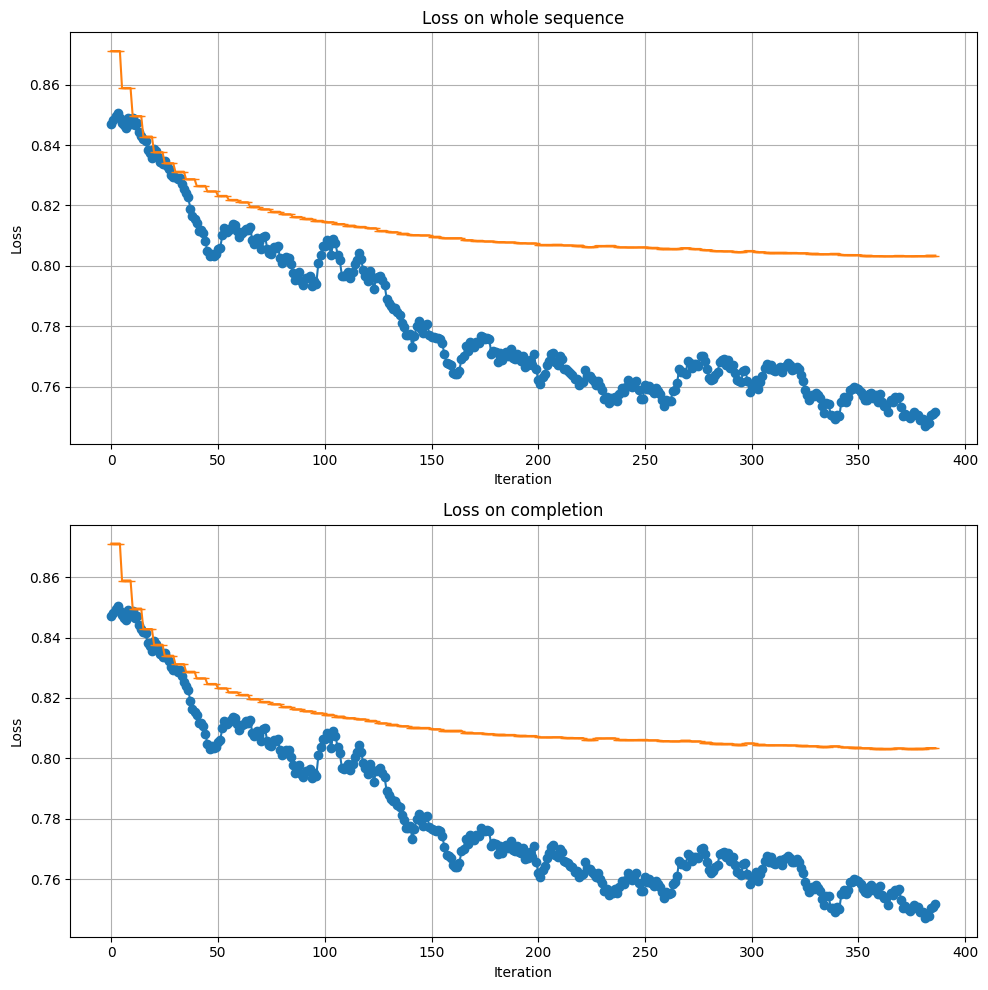

Plotted: 11840 steps, Val Size is 128


In [ ]:
torch.cuda.empty_cache()
# total_whole_input_loss = 0
# total_completion_loss = 0
# total_tokens = 0
# total_completion_tokens = 0
# train_losses_whole_input = []
# curr_train_loss_whole_input = []
# train_losses_completion = []
# curr_train_loss_completion = []

# val_losses_whole_input = list()
# val_losses_completion = list()


ACCUM_STEPS_NUM = 64
num_epochs = 2
for ep in range(num_epochs):
    loader = DataLoader(torch_dataset, batch_size=1, shuffle=True)
    
    new_loader = list()
    for idx, hf_dp in enumerate(tqdm(loader)):
        # torch.cuda.empty_cache()
        # if idx > 20:
        #     break
        new_loader.append(hf_dp)
        dp = DatapointComposed.from_hf_datapoint(hf_dp)
        _is_oom = True
        seq_len = 2048 # CONTEXT_MAX_LEN_TOKENS
        context_ratio = 0.75
    
        while _is_oom:
    
            try:
                inputs, context_len, completion_len = compose_input_sequence(dp, int(seq_len * (1 + context_ratio)), tokenizer, context_ratio)
                if inputs is not None:
                    assert abs(completion_len+context_len-inputs['input_ids'].shape[1])<2
                    # full_len = inputs['input_ids'].shape[1]
                    inputs = inputs.to(model_lora.device)
                    outputs = get_outputs(inputs['input_ids'], context_len, completion_len, model_lora)
                    # outputs = model_lora.forward(**inputs)
                    # print(seq_len, "OK")
                    _is_oom = False
                    
                else:
                    continue
            except torch.cuda.OutOfMemoryError as e:
                # print(seq_len, "OOM", end=' | ')
                seq_len = int(seq_len * 0.9)
                # print(e)
    
        logits_size = outputs['logits'].size(-1)
        loss_completion = criterion(outputs['logits'].view(-1, outputs['logits'].size(-1))[-completion_len:-1, :], inputs['input_ids'].view(-1)[-completion_len+1:])
        # print(context_input_len)
        # print(loss.item())
        
        (loss_completion).backward()
        # print(loss_completion.item())
        detached_logits = outputs['logits'].detach()
        
        # for 0 output logit we have corresponding 1st input
        loss_whole_input = loss_completion #criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:])
            
        if (idx+1) % ACCUM_STEPS_NUM ==0:
            train_losses_whole_input.append(sum(curr_train_loss_whole_input)/len(curr_train_loss_whole_input))
            train_losses_completion.append(sum(curr_train_loss_completion)/len(curr_train_loss_completion))
            curr_train_loss_whole_input = []
            curr_train_loss_completion=[]
            for param in model_lora.parameters():
                if param.requires_grad:
                    if param.grad is not None:
                        param.grad /= ACCUM_STEPS_NUM
            
            optimizer.step()
            optimizer.zero_grad()
    
        if (idx+1) % (ACCUM_STEPS_NUM*5) == 0:
            curr_val_loss_whole, curr_val_loss_completion, val_count = get_val_loss(model_lora)
            while len(val_losses_completion) < len(train_losses_completion):
                val_losses_completion.append(curr_val_loss_completion)
            while len(val_losses_whole_input) < len(train_losses_whole_input):
                val_losses_whole_input.append(curr_val_loss_whole)
            live_plot(
                ema_smoothing(train_losses_whole_input), ema_smoothing(train_losses_completion),
                val_losses_whole_input, val_losses_completion,
            )
            print(f"Plotted: {(idx+1)} steps, Val Size is {val_count}")
            
        
        curr_train_loss_whole_input.append(loss_whole_input.item())
        curr_train_loss_completion.append(loss_completion.item())
        total_whole_input_loss += loss_whole_input.item() * (inputs['input_ids'].size(0)-1)  # Accumulate scaled loss
        total_completion_loss += loss_completion.item() * (completion_len -1)  # Accumulate scaled loss
        total_tokens += (inputs['input_ids']).size(-1) - 1  # Count tokens processed
        total_completion_tokens += completion_len - 1
        # TODO validation


avg_loss = total_whole_input_loss / total_tokens
perplexity = math.exp(avg_loss)  # Calculate perplexity as exp of the average loss

avg_completion_loss = total_completion_loss / total_completion_tokens
perplexity = math.exp(avg_completion_loss)




    

In [20]:
def get_input_ids(dp, tokenizer, completion_len, context_factor, max_seq_len=2048):
    context = dp.context[0]
    completion = dp.completion[0]
    context_len = (max_seq_len-completion_len) * context_factor
    context = context[-(context_len*10):]
    context_tokens = tokenizer(context, return_tensors='pt')['input_ids']
    context_tokens = context_tokens[..., -context_len:]
    completion_tokens = tokenizer(completion, return_tensors='pt')['input_ids']
    completion_tokens = completion_tokens[..., :completion_len]
    
    return torch.cat((context_tokens, completion_tokens), dim=-1), context_len, completion_len
    print(context_tokens.shape, completion_tokens.shape,)
                               
    

In [21]:
get_input_ids(dp, tokenizer, completion_len=20, context_factor=4)

NameError: name 'dp' is not defined

In [22]:
def get_val_loss(model, val_loader=val_loader, token_factor=1, true_completion_lens=None):
    model.eval()
    count = 0
    curr_val_loss_whole_input = list()
    curr_val_loss_completion = list()
    with torch.no_grad():
        for idx, hf_dp in enumerate(tqdm(val_loader)):
            # if idx>20:
            #     break
            dp = DatapointComposed.from_hf_datapoint(hf_dp)
            seq_len = 2048
            context_ratio = 0.75
            completion_len = 512
            input_ids, context_len, completion_len = get_input_ids(dp, tokenizer, completion_len=completion_len, context_factor=token_factor)
            # true_completion_len = int(seq_len*(1-context_ratio))
            # inputs, context_len, completion_len = compose_input_sequence(dp, int(seq_len * (1 + (token_factor-1)*context_ratio)), tokenizer, context_ratio)
            # if inputs is None:
                # continue
            # input_ids = inputs['input_ids'].clone()
            # if true_completion_lens is not None:
            #     completion_len = true_completion_lens[idx]
            
            # inputs['input_ids'] = inputs['input_ids'][:, :(context_len + true_completion_len)] 
                # input_ids = input_ids[:, :(context_len + completion_len)]
            count += 1
            input_ids = input_ids.to(model_lora.device)
            # outputs, t_outputs = get_outputs(inputs['input_ids'], context_len, completion_len, model, val=True)
            # outputs = model.forward(**inputs)
            outputs = get_outputs(input_ids, context_len, completion_len, model, token_factor=token_factor)
        
            logits_size = outputs['logits'].size(-1)
            loss_completion = criterion(
                outputs['logits'].view(-1, outputs['logits'].size(-1))[-completion_len:-1, :], 
                input_ids.view(-1)[-completion_len+1:])
            # t_logits_size = t_outputs['logits'].size(-1)
            # t_loss_completion = criterion(t_outputs['logits'].view(-1, t_outputs['logits'].size(-1))[-completion_len:-1, :], inputs['input_ids'].view(-1)[-completion_len+1:])

            
            detached_logits = outputs['logits'].detach()
            # if idx < 20:
                # print(f'With pairing: {loss_completion.item():.4f}, Standard: {t_loss_completion.item():.4f}')
            # for 0 output logit we have corresponding 1st input
            loss_whole_input = loss_completion #criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:])
            curr_val_loss_whole_input.append(loss_whole_input.item())
            curr_val_loss_completion.append(loss_completion.item())
    val_msg = f'Token Factor: {token_factor}, Loss: {sum(curr_val_loss_completion) / len(curr_val_loss_completion) :.4f}, '
    print(f'Token Factor: {token_factor}, Loss: {sum(curr_val_loss_completion) / len(curr_val_loss_completion) :.4f}, ',
            f'input shape: {input_ids.shape}, output shape: {outputs.logits.shape}')

    return (sum(curr_val_loss_whole_input) / len(curr_val_loss_whole_input), 
    sum(curr_val_loss_completion) / len(curr_val_loss_completion), 
    count, val_msg)

In [71]:
for tf in range(1, 16):
    get_val_loss(model_lora, token_factor=tf, true_completion_lens=true_completion_lens)

  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 1, Loss: 0.7529,  input shape: torch.Size([1, 2048]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
2 ** 4 * 64 

1024

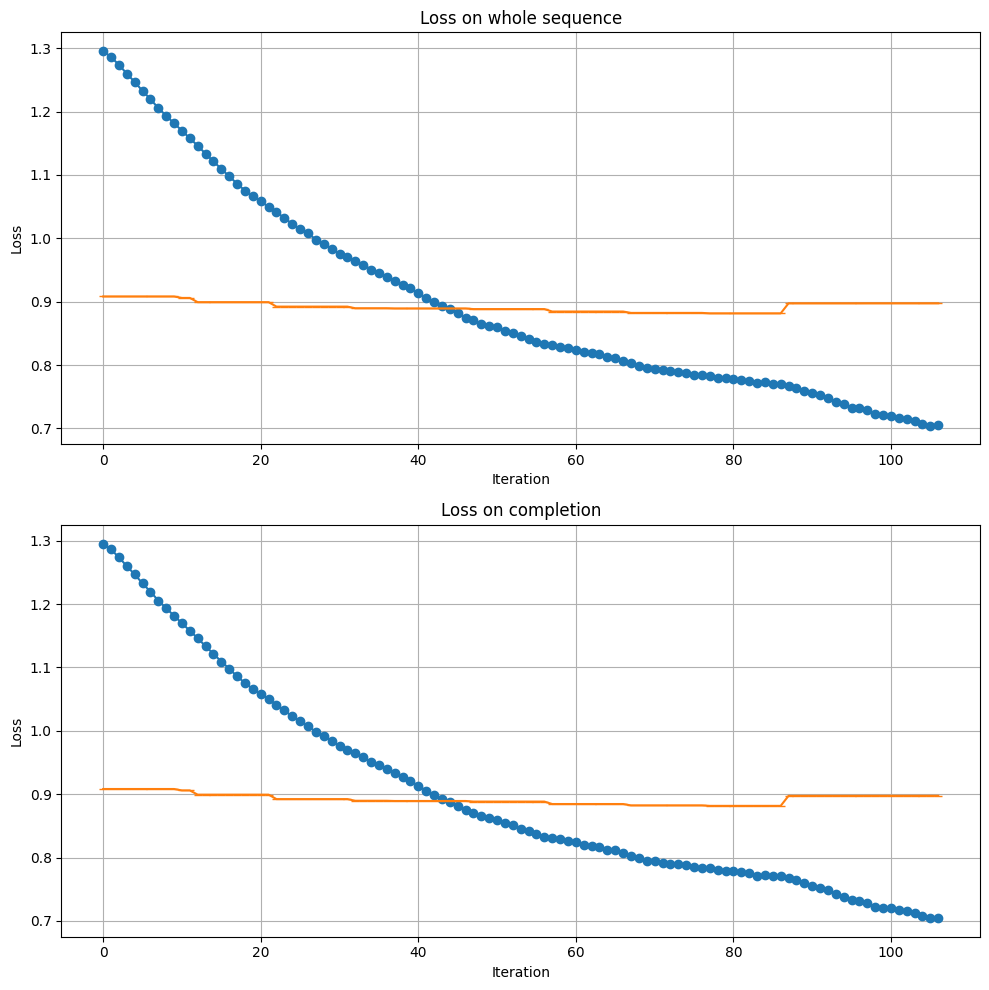

Plotted: 2561 steps, Val Size is 128
Token Factor: 2, Loss: 0.8975, 


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
torch.cuda.empty_cache()
total_whole_input_loss = 0
total_completion_loss = 0
total_tokens = 0
total_completion_tokens = 0
train_losses_whole_input = []
curr_train_loss_whole_input = []
train_losses_completion = []
curr_train_loss_completion = []

val_losses_whole_input = list()
val_losses_completion = list()



num_epochs = 5
for ep in range(num_epochs):
    ACCUM_STEPS_NUM = 64 * 2**(num_epochs-ep-1)
    loader = DataLoader(torch_dataset, batch_size=1, shuffle=True)
    
    new_loader = list()
    for idx, hf_dp in enumerate(tqdm(loader)):
        model_lora.train()
        # torch.cuda.empty_cache()
        # if idx > 20:
        #     break
        new_loader.append(hf_dp)
        dp = DatapointComposed.from_hf_datapoint(hf_dp)
        _is_oom = True
        seq_len = 2048 # CONTEXT_MAX_LEN_TOKENS
        context_ratio = 0.75

        tfg, clg = random.Random(), random.Random()
        tfg.seed(111)
        clg.seed(123)
        token_factor = tfg.randint(5, 15)
        
        completion_len = clg.randint(256, 1024)
        input_ids, context_len, completion_len = get_input_ids(
            dp, tokenizer, 
            completion_len=completion_len, context_factor=token_factor,
            max_seq_len=seq_len
        )


        # inputs, context_len, completion_len = compose_input_sequence(dp, int(seq_len * (1 + context_ratio)), tokenizer, context_ratio)
        input_ids = input_ids.to(model_lora.device)
        outputs = get_outputs(input_ids, context_len, completion_len, model_lora, token_factor=token_factor)
    
    
        logits_size = outputs['logits'].size(-1)
        loss_completion = criterion(outputs['logits'].view(-1, outputs['logits'].size(-1))[-completion_len:-1, :], input_ids.view(-1)[-completion_len+1:])
        # print(context_input_len)
        # print(loss.item())
        
        (loss_completion).backward()
        # print(loss_completion.item())
        detached_logits = outputs['logits'].detach()
        
        # for 0 output logit we have corresponding 1st input
        loss_whole_input = loss_completion #criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:])
            
        if (idx+1) % ACCUM_STEPS_NUM ==0:
            train_losses_whole_input.append(sum(curr_train_loss_whole_input)/len(curr_train_loss_whole_input))
            train_losses_completion.append(sum(curr_train_loss_completion)/len(curr_train_loss_completion))
            curr_train_loss_whole_input = []
            curr_train_loss_completion=[]
            for param in model_lora.parameters():
                if param.requires_grad:
                    if param.grad is not None:
                        param.grad /= ACCUM_STEPS_NUM
            
            optimizer.step()
            optimizer.zero_grad()
    
        if (idx) % (ACCUM_STEPS_NUM*10) == 0:
            curr_val_loss_whole, curr_val_loss_completion, val_count, val_msg = get_val_loss(model_lora, token_factor=2)
            while len(val_losses_completion) < len(train_losses_completion):
                val_losses_completion.append(curr_val_loss_completion)
            while len(val_losses_whole_input) < len(train_losses_whole_input):
                val_losses_whole_input.append(curr_val_loss_whole)
            if len(train_losses_whole_input) > 0:
                live_plot(
                    ema_smoothing(train_losses_whole_input), ema_smoothing(train_losses_completion),
                    val_losses_whole_input, val_losses_completion,
                )
                print(f"Plotted: {(idx+1)} steps, Val Size is {val_count}")
                print(val_msg)
            
        
        curr_train_loss_whole_input.append(loss_whole_input.item())
        curr_train_loss_completion.append(loss_completion.item())
        total_whole_input_loss += loss_whole_input.item() * (input_ids.size(0)-1)  # Accumulate scaled loss
        total_completion_loss += loss_completion.item() * (completion_len -1)  # Accumulate scaled loss
        total_tokens += (input_ids).size(-1) - 1  # Count tokens processed
        total_completion_tokens += completion_len - 1
        # TODO validation


avg_loss = total_whole_input_loss / total_tokens
perplexity = math.exp(avg_loss)  # Calculate perplexity as exp of the average loss

avg_completion_loss = total_completion_loss / total_completion_tokens
perplexity = math.exp(avg_completion_loss)




    

In [ ]:
for tf in range(1, 16):
    get_val_loss(model_lora, token_factor=tf, true_completion_lens=None)

  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 1, Loss: 0.9042,  input shape: torch.Size([1, 2048]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 2, Loss: 0.9446,  input shape: torch.Size([1, 3584]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 3, Loss: 0.9849,  input shape: torch.Size([1, 5120]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 4, Loss: 1.0027,  input shape: torch.Size([1, 6656]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 5, Loss: 1.0087,  input shape: torch.Size([1, 8192]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 6, Loss: 1.0154,  input shape: torch.Size([1, 9728]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 7, Loss: 1.0232,  input shape: torch.Size([1, 11264]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 8, Loss: 1.0310,  input shape: torch.Size([1, 12800]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 9, Loss: 1.0417,  input shape: torch.Size([1, 14336]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 10, Loss: 1.0506,  input shape: torch.Size([1, 15872]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 11, Loss: 1.0601,  input shape: torch.Size([1, 17408]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 12, Loss: 1.0675,  input shape: torch.Size([1, 18944]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 13, Loss: 1.0753,  input shape: torch.Size([1, 20480]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

In [65]:
for tf in range(1, 16):
    get_val_loss(model_lora, token_factor=tf, true_completion_lens=true_completion_lens)

  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 1, Loss: 0.7526,  input shape: torch.Size([1, 2048]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 2, Loss: 0.8550,  input shape: torch.Size([1, 3584]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 3, Loss: 0.8912,  input shape: torch.Size([1, 5120]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 4, Loss: 0.9013,  input shape: torch.Size([1, 6656]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 5, Loss: 0.9242,  input shape: torch.Size([1, 8192]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 6, Loss: 0.9426,  input shape: torch.Size([1, 9728]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 7, Loss: 0.9591,  input shape: torch.Size([1, 11264]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 8, Loss: 0.9726,  input shape: torch.Size([1, 12800]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 9, Loss: 0.9900,  input shape: torch.Size([1, 14336]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 10, Loss: 1.0061,  input shape: torch.Size([1, 15872]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 11, Loss: 1.0330,  input shape: torch.Size([1, 17408]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 12, Loss: 1.0639,  input shape: torch.Size([1, 18944]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

Token Factor: 13, Loss: 1.0964,  input shape: torch.Size([1, 20480]), output shape: torch.Size([1, 2048, 32256])


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# print(len(train_losses))

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()